In [1]:
!pip install joypy
!pip install catboost
!pip install dask-expr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.5/244.5 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 28.8 MB/s eta 0:00:00
  Attempting uninstall: dask
    Found existing installation: dask 2024.10.0
    Uninstalling dask-2024.10.0:
      Successfully uninstalled dask-2024.10.0


In [2]:
import os
import pandas as pd
import numpy as np
from scipy.stats import norm
import kagglehub
import seaborn as sns
# from joypy import joyplot
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

# models
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, auc
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import log_loss
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


## Load data
Option 1: from google drive (if saved locally)

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

file_path = "/content/drive/MyDrive/Book2.xlsx"
df = pd.read_excel(file_path)

Mounted at /content/drive


Option 2: from kagglehub

In [3]:
path = kagglehub.dataset_download("chenzhejin/amex-cleaned-data-for-course-project")
filename = "Book2.xlsx"
file_path = os.path.join(path, filename)
df = pd.read_excel(file_path)

100%|██████████| 19.3M/19.3M [00:00<00:00, 62.4MB/s]

Extracting files...


## Drop the redundant features

In [4]:

df['trust_identity'] = df['trust_identity'].fillna(2)
df['addr_mismatch'] = df['addr_mismatch'].fillna(2)
high_corr_features_to_drop = [
    "basic_max_trd_tnr",       # correlated with old_open_trd_ms
    "basic_old_open_trd_ms",   # correlated with old_open_trd_ms
    "no_open_trd",             # correlated with no_trd
    "basic_no_trd",            # correlated with no_trd
    "no_trd",                  # correlated with no_trd_del
    "addr_changes",            # correlated with uid_addr_matches
    "uid_nid_matches",         # correlated with uid_addr_matches
    "no_uid_to_addr",          # correlated with no_nid_to_addr
    "income_incons",           # correlated with debt_cap
    "spend",                   # correlated with payments
    "merchant1",               # correlated with merchant1_ten
    "merchant2",               # correlated with merchant2_ten
    "merchant3"                # correlated with merchant3_ten
]
# Drop the redundant features
df_optimized = df.drop(columns=high_corr_features_to_drop)

X = df_optimized.drop(columns=["unique_identifier", "default_ind"])
y = df_optimized["default_ind"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print("Contains NaN:", X.isnull().any().any())
print("Contains Inf:", np.isinf(X).any().any())

Contains NaN: False
Contains Inf: False


## Helper Functions

In [5]:
def PR_Curve(model):
  precision, recall, thresholds = precision_recall_curve(model.y_test, model.y_pred_proba)
  plt.figure(figsize=(8, 6))
  plt.plot(recall, precision, marker='.', label=f'{model.name} (PR Curve)')
  plt.axvline(x=model.threshold, color='red', linestyle='--', label=f'Threshold={model.threshold}')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Precision-Recall Curve')
  plt.legend()
  plt.show()

def model_cm(model):
  cm = confusion_matrix(model.y_test, model.y_pred)
  return cm

def model_cr(model):
  cr = classification_report(model.y_test, model.y_pred)
  return cr

def model_roc_auc_score(model):
  ras = roc_auc_score(model.y_test, model.y_pred_proba)
  return ras

In [6]:
class DNN_model:
  def __init__(self, X_train, X_test, y_train, y_test):
    self.name = "DNN_model"
    self.X_train, self.y_train= X_train, y_train
    self.X_validate, self.X_test, self.y_validate, self.y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)
    self.loss = None
    self.accuracy = None
    self.y_pred_proba = None
    self.y_pred = None
    self.threshold = None
    self.class_weight = None

    self.set_model()

  def set_model(self, module="standard"):
    if module == "standard":
      scaler = StandardScaler()
      self.X_train = scaler.fit_transform(self.X_train)
      self.X_validate = scaler.transform(self.X_validate)
      self.X_test = scaler.transform(self.X_test)

      self.early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
      self.reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
      self.model = Sequential([
          Input(shape=(self.X_train.shape[1],)),
          Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
          BatchNormalization(),
          Dropout(0.4),
          Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
          BatchNormalization(),
          Dropout(0.4),
          Dense(1, activation='sigmoid')
      ])
      self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
      self.early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
      self.reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

    if module == "advanced":
      weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=self.y_train)
      self.class_weight = dict(enumerate(weights))
      sm = SMOTE(random_state=42)
      self.X_train, self.y_train = sm.fit_resample(self.X_train, self.y_train)

  def train(self):
    self.model.fit(self.X_train, self.y_train,
          validation_data=(self.X_validate, self.y_validate),
          epochs=100, batch_size=16,
          class_weight=self.class_weight,
          callbacks=[self.early_stopping, self.reduce_lr])

  def evaluate(self):
    self.loss, self.accuracy = self.model.evaluate(self.X_test, self.y_test)
    print(f"Test Loss: {self.loss:.4f}, Test Accuracy: {self.accuracy:.4f}")

  def predict(self, new_data=None, threshold = 0.5):
    self.threshold = threshold
    if new_data is None:
      new_data = self.X_test
    else:
      scaler = StandardScaler()
      new_data = scaler.fit_transform(new_data)
    self.y_pred_proba = self.model.predict(new_data)
    self.y_pred = (self.y_pred_proba > self.threshold).astype(int)
    return self.y_pred, self.y_pred_proba


class Catboost:
  def __init__(self, X_train, X_test, y_train, y_test):
    self.name = "Catboost"
    self.X_train, self.y_train= X_train, y_train
    self.X_validate, self.X_test, self.y_validate, self.y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

    self.set_model()

  def set_model(self, module="standard", iterations=500, learning_rate=0.1, depth=6, class_weights=[1, 10]):
    if module == "advanced":
      sm = SMOTE(random_state=42)
      self.X_train, self.y_train = sm.fit_resample(self.X_train, self.y_train)

    self.model = CatBoostClassifier(
          iterations=iterations,
          learning_rate=learning_rate,
          depth=depth,
          loss_function='Logloss',
          eval_metric='Accuracy',
          random_seed=42,
          verbose=50,
          class_weights=class_weights
      )


  def train(self):
    self.model.fit(
        self.X_train, self.y_train,
        eval_set=(self.X_validate, self.y_validate),
        early_stopping_rounds=50
    )

  def evaluate(self):
    self.loss, self.accuracy = self.model.best_score_["validation"]["Logloss"], self.model.score(self.X_test, self.y_test)
    print(f"Test Loss: {self.loss:.4f}, Test Accuracy: {self.accuracy:.4f}")

  def predict(self, new_data=None, threshold = 0.5):
    self.threshold = threshold
    if new_data is None:
      new_data = self.X_test
    self.y_pred_proba = self.model.predict_proba(self.X_test)[:, 1]
    self.y_pred = self.model.predict(self.X_test)
    return self.y_pred, self.y_pred_proba




In [7]:
class SVMModel:
    def __init__(self, X_train, X_test, y_train, y_test):
        self.name = "SVM"
        self.X_train, self.y_train = X_train, y_train
        self.X_validate, self.X_test, self.y_validate, self.y_test = train_test_split(
            X_test, y_test, test_size=0.5, random_state=42, stratify=y_test
        )
        self.model = None
        self.loss = None
        self.accuracy = None
        self.y_pred = None
        self.y_pred_proba = None
        self.threshold = None

    def set_model(self, mode="standard", kernel="rbf", C=1, gamma="scale"):
        """Configure the SVM pipeline model"""
        if mode == "standard":
            self.model = Pipeline([
                ('imputer', SimpleImputer(strategy='mean')),
                ('scaler', StandardScaler()),
                ('svm', SVC(kernel=kernel, C=C, gamma=gamma, probability=True, random_state=42))
            ])
        elif mode == "advance":
            # Use SMOTE for handling class imbalance
            self.smote = SMOTE(random_state=42)
            self.model = Pipeline([
                ('scaler', StandardScaler()),
                ('svm', SVC(kernel=kernel, C=C, gamma=gamma, class_weight='balanced', probability=True, random_state=42))
            ])
        else:
            raise ValueError(f"Unknown mode: {mode}")

    def train(self):
        """Train the SVM model"""
        if hasattr(self, 'smote'):
            # Resample the training data using SMOTE
            self.X_train, self.y_train = self.smote.fit_resample(self.X_train, self.y_train)
        self.model.fit(self.X_train, self.y_train)

    def evaluate(self, threshold=0.5):
        """Evaluate the SVM model"""
        self.y_pred_proba = self.model.predict_proba(self.X_test)[:, 1]
        self.y_pred = (self.y_pred_proba >= threshold).astype(int)

        # Calculate log loss
        from sklearn.metrics import log_loss, accuracy_score
        self.loss = log_loss(self.y_test, self.y_pred_proba)
        self.accuracy = accuracy_score(self.y_test, self.y_pred)

        print(f"Test Loss: {self.loss:.4f}, Test Accuracy: {self.accuracy:.4f}")

    def predict(self, new_data=None, threshold=0.5):
        """Predict new data with optional threshold adjustment"""
        self.threshold = threshold
        if new_data is None:
            new_data = self.X_test
        self.y_pred_proba = self.model.predict_proba(new_data)[:, 1]
        self.y_pred = (self.y_pred_proba >= threshold).astype(int)
        return self.y_pred, self.y_pred_proba


In [8]:
class NBCModel:
    def __init__(self, X_train, X_test, y_train, y_test):
        self.name = "Naive Bayes"
        self.X_train, self.y_train = X_train, y_train
        self.X_validate, self.X_test, self.y_validate, self.y_test = train_test_split(
            X_test, y_test, test_size=0.5, random_state=42, stratify=y_test
        )
        self.model = None
        self.loss = None
        self.accuracy = None
        self.y_pred = None
        self.y_pred_proba = None
        self.threshold = None

    def set_model(self, mode="standard"):
        """Configure the Naive Bayes model"""
        self.model = GaussianNB()
        if mode == "advance":
            self.smote = SMOTE(random_state=42)
        else:
            self.smote = None

    def train(self):
        """Train the Naive Bayes model"""
        # Handle missing values
        self.X_train = self.X_train.fillna(self.X_train.mean())
        self.X_test = self.X_test.fillna(self.X_train.mean())

        if self.smote:
            # Resample the training data using SMOTE
            self.X_train, self.y_train = self.smote.fit_resample(self.X_train, self.y_train)

        self.model.fit(self.X_train, self.y_train)

    def evaluate(self, threshold=0.5):
        """Evaluate the Naive Bayes model with adjustable threshold"""
        self.y_pred_proba = self.model.predict_proba(self.X_test)[:, 1]
        self.y_pred = (self.y_pred_proba >= threshold).astype(int)
        self.loss = log_loss(self.y_test, self.y_pred_proba)
        self.accuracy = accuracy_score(self.y_test, self.y_pred)

        print(f"Test Loss: {self.loss:.4f}, Test Accuracy: {self.accuracy:.4f}")

    def predict(self, new_data=None, threshold=0.5):
        """Predict new data with optional threshold adjustment"""
        self.threshold = threshold
        if new_data is None:
            new_data = self.X_test
        self.y_pred_proba = self.model.predict_proba(new_data)[:, 1]
        self.y_pred = (self.y_pred_proba >= threshold).astype(int)
        return self.y_pred, self.y_pred_proba


In [9]:
class GBModel:
    def __init__(self, X_train, X_test, y_train, y_test):
        self.name = "Gradient Boosting"
        self.X_train, self.y_train = X_train, y_train
        self.X_validate, self.X_test, self.y_validate, self.y_test = train_test_split(
            X_test, y_test, test_size=0.5, random_state=42, stratify=y_test
        )
        self.model = None
        self.loss = None
        self.accuracy = None
        self.y_pred = None
        self.y_pred_proba = None
        self.threshold = None

    def set_model(self, mode="standard", param_grid=None):
        """Configure the Gradient Boosting model"""
        if mode == "standard":
            self.model = GradientBoostingClassifier(
                n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42
            )
        else:
            raise ValueError(f"Unknown mode: {mode}")

    def train(self):
        """Train the Gradient Boosting model"""
        if hasattr(self, 'smote'):
            # Apply SMOTE for handling class imbalance
            self.X_train, self.y_train = self.smote.fit_resample(self.X_train, self.y_train)
            self.grid_search.fit(self.X_train, self.y_train)
            self.model = self.grid_search.best_estimator_
        else:
            self.model.fit(self.X_train, self.y_train)

    def evaluate(self, threshold=0.5):
        """Evaluate the Gradient Boosting model"""
        self.y_pred_proba = self.model.predict_proba(self.X_test)[:, 1]
        self.y_pred = (self.y_pred_proba >= threshold).astype(int)

        self.loss = log_loss(self.y_test, self.y_pred_proba)
        self.accuracy = accuracy_score(self.y_test, self.y_pred)

        print(f"Test Loss: {self.loss:.4f}, Test Accuracy: {self.accuracy:.4f}")

    def predict(self, new_data=None, threshold=0.5):
        """Predict new data with optional threshold adjustment"""
        self.threshold = threshold
        if new_data is None:
            new_data = self.X_test
        self.y_pred_proba = self.model.predict_proba(new_data)[:, 1]
        self.y_pred = (self.y_pred_proba >= threshold).astype(int)
        return self.y_pred, self.y_pred_proba

In [10]:
class KNNModel:
  def __init__(self, X_train, X_test, y_train, y_test):
    self.name = "KNN"
    self.X_train, self.y_train = X_train, y_train
    self.X_validate, self.X_test, self.y_validate, self.y_test = train_test_split(
        X_test, y_test, test_size=0.5, random_state=42, stratify=y_test
    )
    self.model = None
    self.loss = None
    self.accuracy = None
    self.y_pred = None
    self.y_pred_proba = None
    self.threshold = None
    self.n_neighbor = 5 # default value

  def set_model(self, mode='standard', n=None, tuning_on="recall"):
    if n:
      self.n_neighbor = n
    if mode != "standard":
      sm = SMOTE(random_state=42)
      self.X_train, self.y_train = sm.fit_resample(self.X_train, self.y_train)
      # tuning k
      k_range = range(1, 11)
      recalls = []
      precisions = []
      f1_scores = []
      for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
        knn.fit(self.X_train, self.y_train)
        y_pred = knn.predict(self.X_test)

        recalls.append(recall_score(self.y_test, y_pred, pos_label=1))
        precisions.append(precision_score(self.y_test, y_pred, pos_label=1))
        f1_scores.append(f1_score(self.y_test, y_pred, pos_label=1))
      if tuning_on == 'recall':
        self.n_neighbor = k_range[np.argmax(recalls)]
      elif tuning_on == 'f1':
        max_idx = k_range[np.argmax(f1_scores)]
      else:
        max_idx = k_range[np.argmax(precisions)]

    self.model = KNeighborsClassifier(n_neighbors=self.n_neighbor, weights='distance')

  def train(self):
      self.model.fit(self.X_train, self.y_train)

  def evaluate(self, threshold=0.5):
      self.y_pred_proba = self.model.predict_proba(self.X_test)[:, 1]
      self.y_pred = (self.y_pred_proba >= threshold).astype(int)
      self.loss = log_loss(self.y_test, self.y_pred_proba)
      self.accuracy = accuracy_score(self.y_test, self.y_pred)
      print(f"Test Loss: {self.loss:.4f}, Test Accuracy: {self.accuracy:.4f}")

  def predict(self, new_data=None, threshold=0.5):
      self.threshold = threshold
      if new_data is None:
          new_data = self.X_test
      self.y_pred_proba = self.model.predict_proba(new_data)[:, 1]
      self.y_pred = (self.y_pred_proba >= threshold).astype(int)
      return self.y_pred, self.y_pred_proba

In [11]:
#Random Forest Model

class RandomForestModel:
    def __init__(self, X_train, X_test, y_train, y_test):
        self.name = "RandomForest"
        self.X_validate, self.X_test, self.y_validate, self.y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)
        # self.X_test, self.y_test = X_test, y_test
        self.X_train, self.y_train = X_train, y_train
        self.X_train_resampled, self.y_train_resampled = None, None
        self.model = None
        self.smote = None
        self.best_model = None
        self.best_score = -float('inf')
        self.best_params = None
        self.y_pred_proba = None
        self.y_pred = None
        self.threshold = None

    def set_model(self, mode="standard", param_grid=None):
        """Configure the Random Forest model"""
        if mode == "standard":
            # Basic Random Forest model
            self.model = RandomForestClassifier(
                n_estimators=100,
                random_state=42,
                class_weight='balanced'
            )
        elif mode == "advanced":
            # SMOTE for handling class imbalance
            self.smote = SMOTE(random_state=42)
            if param_grid is None:
                param_grid = [
                    {'n_estimators': 100, 'max_depth':8},
                    {'n_estimators': 150, 'max_depth': 10},
                    {'n_estimators': 200, 'max_depth': 15},
                    {'n_estimators': 100, 'max_depth':None},
                ]

            # Iterate through parameter combinations
            for params in param_grid:
                print(f"Training model with parameters: {params}")
                # Apply SMOTE to handle class imbalance
                self.X_train_resampled, self.y_train_resampled = self.smote.fit_resample(self.X_train, self.y_train)

                # Train the model
                candidate_model = RandomForestClassifier(
                    n_estimators=params['n_estimators'],
                    max_depth=params['max_depth'],
                    class_weight='balanced',
                    random_state=42
                )
                candidate_model.fit(self.X_train_resampled, self.y_train_resampled)

                # Validate the model on the test set
                y_pred_proba = candidate_model.predict_proba(self.X_test)[:, 1]
                y_pred = (y_pred_proba >= 0.3).astype(int)  # Default threshold
                f1 = f1_score(self.y_test, y_pred)

                # Update the best model if the current one is better
                if f1 > self.best_score:
                    self.best_model = candidate_model
                    self.best_score = f1
                    self.best_params = params

            # Set the best model
            self.model = self.best_model
            print(f"Best model parameters: {self.best_params}")
            print(f"Best F1-Score: {self.best_score:.4f}")

        else:
            raise ValueError(f"Unknown mode: {mode}")

    def train(self):
        """Train the Random Forest model"""
        if self.model is None:
            raise ValueError("Model not set. Call `set_model` first.")

        if hasattr(self, 'smote') and self.smote:
            # SMOTE has already been applied in `set_model` for advanced mode
            pass
        else:
            # For standard mode, train directly on the original data
            self.model.fit(self.X_train, self.y_train)

    def evaluate(self):
        """Evaluate the model"""
        self.y_pred_proba = self.model.predict_proba(self.X_test)[:, 1]
        self.threshold = 0.5
        self.y_pred = (self.y_pred_proba >= self.threshold).astype(int)

        # Calculate metrics
        train_accuracy = accuracy_score(self.y_train, self.model.predict(self.X_train))
        test_accuracy = accuracy_score(self.y_test, self.y_pred)
        print(f"Training Accuracy: {train_accuracy:.4f}")
        print(f"Testing Accuracy: {test_accuracy:.4f}")


    def predict(self, new_data=None, threshold=0.5):
        """Predict on new data"""
        self.threshold = threshold
        if new_data is None:
            new_data = self.X_test
        y_pred_proba = self.model.predict_proba(new_data)[:, 1]
        y_pred = (y_pred_proba >= self.threshold).astype(int)
        return y_pred, y_pred_proba


In [12]:
class XGBoostModel:
    def __init__(self, X_train, X_test, y_train, y_test):
        self.name = "XGBoost"
        self.X_train, self.y_train = X_train, y_train
        self.X_validate, self.X_test, self.y_validate, self.y_test = train_test_split(
            X_test, y_test, test_size=0.5, random_state=42, stratify=y_test
        )
        self.model = None
        self.loss = None
        self.accuracy = None
        self.y_pred = None
        self.y_pred_proba = None
        self.threshold = 0.5
        self.best_params = None

    def set_model(self, mode="standard", param_grid=None):
        if mode == "standard":
            self.model = XGBClassifier(
                n_estimators=100,
                learning_rate=0.1,
                max_depth=3,
                random_state=42,
                eval_metric="logloss"
            )
        elif mode == "advanced":
            if param_grid is None:
                raise ValueError("For advanced mode, param_grid must be provided.")
            self.param_grid = param_grid
        else:
            raise ValueError(f"Unknown mode: {mode}")

    def train(self):
        if hasattr(self, 'param_grid'):  # Advanced mode with parameter tuning
            grid_search = GridSearchCV(
                estimator=XGBClassifier(random_state=42, eval_metric="logloss"),
                param_grid=self.param_grid,
                scoring="f1",
                cv=3,
                n_jobs=-1,
                verbose=1
            )
            grid_search.fit(self.X_train, self.y_train)
            self.model = grid_search.best_estimator_
            self.best_params = grid_search.best_params_
            print(f"Best Parameters: {self.best_params}")
        else:  # Standard mode
            self.model.fit(self.X_train, self.y_train)

    def evaluate(self, threshold=0.5):
        self.threshold = threshold
        self.y_pred_proba = self.model.predict_proba(self.X_test)[:, 1]
        self.y_pred = (self.y_pred_proba >= threshold).astype(int)

        self.loss = log_loss(self.y_test, self.y_pred_proba)
        self.accuracy = accuracy_score(self.y_test, self.y_pred)

        print(f"Test Loss: {self.loss:.4f}, Test Accuracy: {self.accuracy:.4f}")


In [13]:
class LightGBMModel:
  def __init__(self, X_train, X_test, y_train, y_test):
    self.name = "LightGBM"
    self.X_train, self.y_train = X_train, y_train
    self.X_validate, self.X_test, self.y_validate, self.y_test = train_test_split(
        X_test, y_test, test_size=0.5, random_state=42, stratify=y_test
    )
    self.model = None
    self.loss = None
    self.accuracy = None
    self.y_pred = None
    self.y_pred_proba = None
    self.threshold = None
    self.cv = None

  def set_model(self, mode='standard', params_space=None):
    if mode == 'advanced':
      sm = SMOTE(random_state=42)
      self.X_train, self.y_train = sm.fit_resample(self.X_train, self.y_train)
      if params_space is None:
        params_space = {
          "n_estimators": np.array([100, 200, 300, 400, 500], dtype="int64"),
          "boosting_type": np.array(["gbdt"]),
          "learning_rate": np.arange(0.01, 0.05, 0.01, dtype="float64"),
          "feature_fraction": np.array([0.3, 0.4, 0.5, 0.6, 0.7], dtype="float64"),
          "bagging_fraction": [0.3, 0.5, 0.7],
          "reg_lambda": [6, 8, 10, 12],
        }
      lgbm_model = LGBMClassifier(
          random_state=0,
          objective="binary",
          metric="binary_logloss",
          verbosity=-1,
      )
      skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
      scoring = ["accuracy", "f1_weighted", "roc_auc"]
      self.cv = RandomizedSearchCV(
          lgbm_model,
          params_space,
          cv=skf,
          scoring=scoring,
          random_state=0,
          refit="roc_auc",
          verbose=1,
      )
    else:
      self.model = LGBMClassifier(
          random_state=0,
          objective="binary",
          metric="binary_logloss",
          verbosity=-1,
          reg_lambda=10,
          n_estimators=400,
          learning_rate=0.05,
          feature_fraction=0.7,
          boosting_type='gbdt',
          bagging_fraction=0.3,
      )

  def train(self):
    if self.cv:
      self.model = self.cv.fit(self.X_train, self.y_train)
    else:
      self.model.fit(self.X_train, self.y_train)

  def evaluate(self, threshold=0.5):
      self.y_pred_proba = self.model.predict_proba(self.X_test)[:, 1]
      self.y_pred = (self.y_pred_proba >= threshold).astype(int)
      self.loss = log_loss(self.y_test, self.y_pred_proba)
      self.accuracy = accuracy_score(self.y_test, self.y_pred)
      print(f"Test Loss: {self.loss:.4f}, Test Accuracy: {self.accuracy:.4f}")

  def predict(self, new_data=None, threshold=0.5):
      self.threshold = threshold
      if new_data is None:
          new_data = self.X_test
      self.y_pred_proba = self.model.predict_proba(new_data)[:, 1]
      self.y_pred = (self.y_pred_proba >= threshold).astype(int)
      return self.y_pred, self.y_pred_proba

## Start Evaluation
---

Test Loss: 0.1904, Test Accuracy: 0.9941
[[9317    2]
 [  53    1]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      9319
           1       0.33      0.02      0.04        54

    accuracy                           0.99      9373
   macro avg       0.66      0.51      0.52      9373
weighted avg       0.99      0.99      0.99      9373

ROC-AUC score: 0.5451804954433992


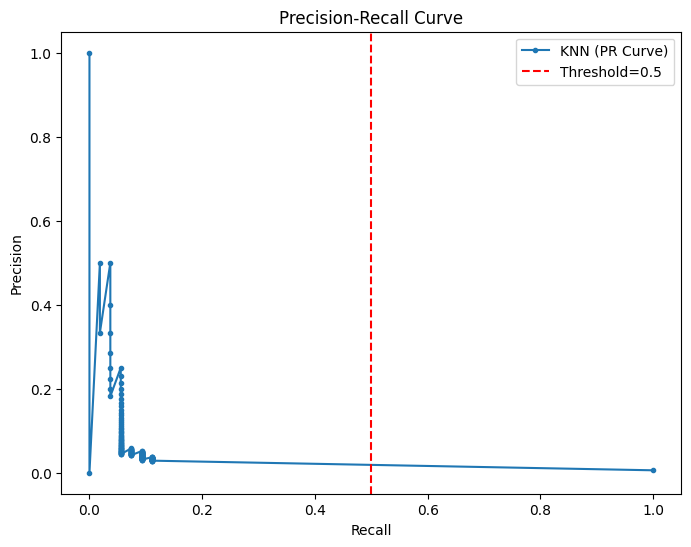

In [ ]:
knn_model_simple = KNNModel(X_train, X_test, y_train, y_test)
knn_model_simple.set_model(mode="standard")
knn_model_simple.train()
knn_model_simple.evaluate()
knn_model_simple.predict()

print(model_cm(knn_model_simple))
print(model_cr(knn_model_simple))
print(f"ROC-AUC score: {model_roc_auc_score(knn_model_simple)}")
PR_Curve(knn_model_simple)

Test Loss: 1.1145, Test Accuracy: 0.9040
[[8452  867]
 [  33   21]]
              precision    recall  f1-score   support

           0       1.00      0.91      0.95      9319
           1       0.02      0.39      0.04        54

    accuracy                           0.90      9373
   macro avg       0.51      0.65      0.50      9373
weighted avg       0.99      0.90      0.94      9373

ROC-AUC score: 0.6501750704454857


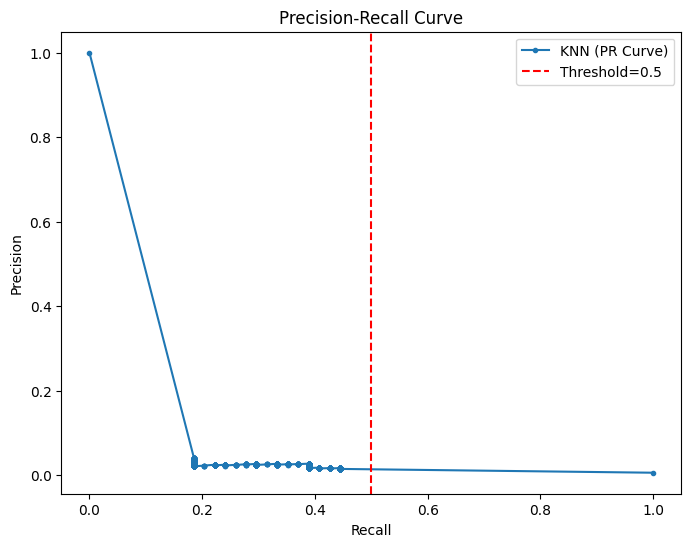

In [ ]:
knn_model = KNNModel(X_train, X_test, y_train, y_test)
knn_model.set_model(mode="advanced")
knn_model.train()
knn_model.evaluate()
knn_model.predict()

print(model_cm(knn_model))
print(model_cr(knn_model))
print(f"ROC-AUC score: {model_roc_auc_score(knn_model)}")
PR_Curve(knn_model)

Test Loss: 0.0172, Test Accuracy: 0.9958
[[9319    0]
 [  39   15]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9319
           1       1.00      0.28      0.43        54

    accuracy                           1.00      9373
   macro avg       1.00      0.64      0.72      9373
weighted avg       1.00      1.00      0.99      9373

ROC-AUC score: 0.976787765338039


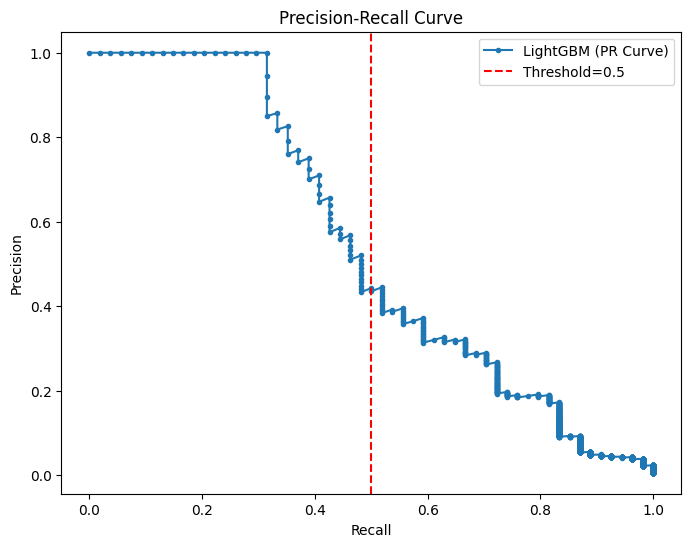

In [ ]:
lgbm_model_1 = LightGBMModel(X_train, X_test, y_train, y_test)
lgbm_model_1.set_model(mode="standard")
lgbm_model_1.train()
lgbm_model_1.evaluate()
lgbm_model_1.predict()

print(model_cm(lgbm_model_1))
print(model_cr(lgbm_model_1))
print(f"ROC-AUC score: {model_roc_auc_score(lgbm_model_1)}")
PR_Curve(lgbm_model_1)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Test Loss: 0.0183, Test Accuracy: 0.9951
[[9307   12]
 [  34   20]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9319
           1       0.62      0.37      0.47        54

    accuracy                           1.00      9373
   macro avg       0.81      0.68      0.73      9373
weighted avg       0.99      1.00      0.99      9373

ROC-AUC score: 0.971636998088334


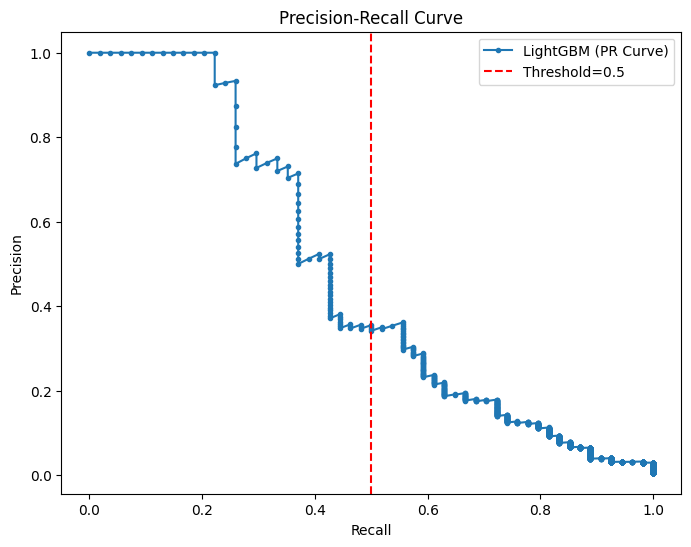

In [ ]:
lgbm_model = LightGBMModel(X_train, X_test, y_train, y_test)
lgbm_model.set_model(mode="advanced")
lgbm_model.train()
lgbm_model.evaluate()
lgbm_model.predict()

print(model_cm(lgbm_model))
print(model_cr(lgbm_model))
print(f"ROC-AUC score: {model_roc_auc_score(lgbm_model)}")
PR_Curve(lgbm_model)

In [ ]:
lgbm_model.model.best_params_

{'reg_lambda': 10,
 'n_estimators': 400,
 'learning_rate': 0.04,
 'feature_fraction': 0.6,
 'boosting_type': 'gbdt',
 'bagging_fraction': 0.3}

Test Loss: 0.0220, Test Accuracy: 0.9950
[[9317    2]
 [  45    9]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9319
           1       0.82      0.17      0.28        54

    accuracy                           0.99      9373
   macro avg       0.91      0.58      0.64      9373
weighted avg       0.99      0.99      0.99      9373

ROC-AUC score: 0.9394645745649073


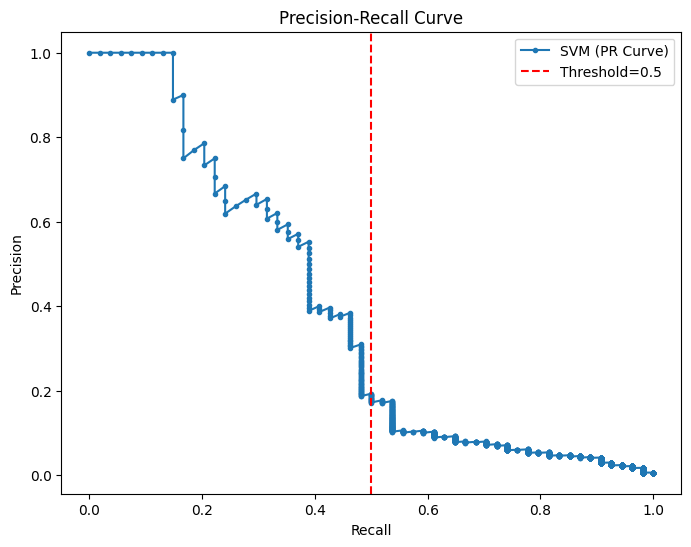

In [ ]:
# Initialize and use the SVM model class
svm_model = SVMModel(X_train, X_test, y_train, y_test)
svm_model.set_model(mode="standard")
svm_model.train()
svm_model.evaluate()
svm_model.predict()

print(model_cm(svm_model))
print(model_cr(svm_model))

print(f"ROC-AUC score: {model_roc_auc_score(svm_model)}")

PR_Curve(svm_model)

For current svm model, the high precision and low recall indicate that your model predicts class 1 accurately but misses many actual defaulters.

To improve recall:

*   Address class imbalance using oversampling, undersampling, or adjusting class weights.
*   Adjust the decision threshold to make the model more sensitive to positive class samples.






Test Loss: 0.0519, Test Accuracy: 0.9935
[[9296   23]
 [  38   16]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9319
           1       0.41      0.30      0.34        54

    accuracy                           0.99      9373
   macro avg       0.70      0.65      0.67      9373
weighted avg       0.99      0.99      0.99      9373

0.9065966384884724


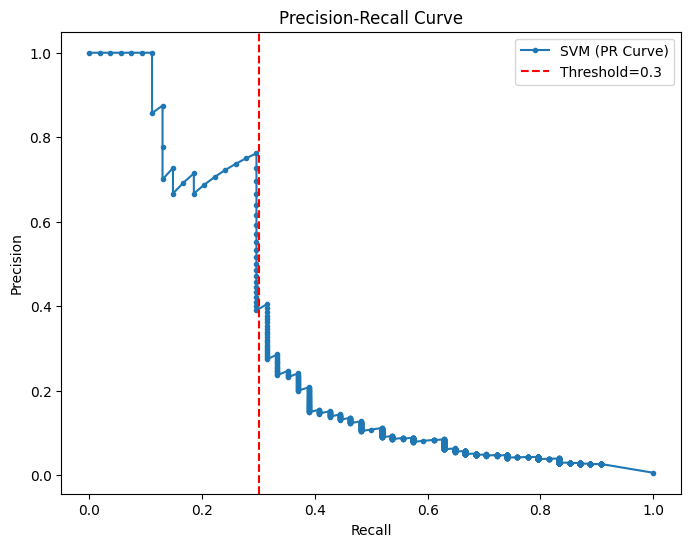

In [ ]:
# Step 2: Initialize and configure the model
svm_model2 = SVMModel(X_train, X_test, y_train, y_test)
svm_model2.set_model(mode="advance")  # Use the advanced model with SMOTE and class weights

svm_model2.train()

# Evaluate the model with threshold = 0.3
svm_model2.evaluate(threshold=0.3)

# Predict with the adjusted threshold
svm_model2.predict(threshold=0.3)

print(model_cm(svm_model2))
print(model_cr(svm_model2))

print(model_roc_auc_score(svm_model2))

PR_Curve(svm_model2)

Test Loss: 0.4353, Test Accuracy: 0.9623
[[9005  314]
 [  39   15]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      9319
           1       0.05      0.28      0.08        54

    accuracy                           0.96      9373
   macro avg       0.52      0.62      0.53      9373
weighted avg       0.99      0.96      0.98      9373

0.6796807001228077


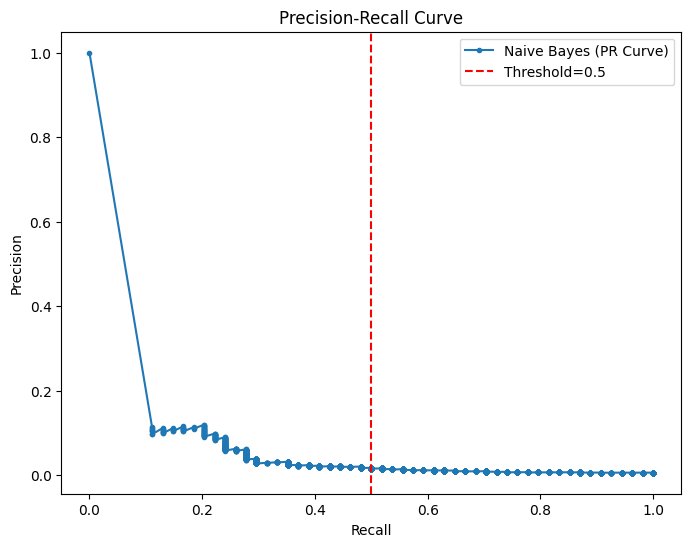

In [ ]:
# NBC
nbc_model = NBCModel(X_train, X_test, y_train, y_test)
nbc_model.set_model(mode="standard")
nbc_model.train()
nbc_model.evaluate()
nbc_model.predict()

print(model_cm(nbc_model))
print(model_cr(nbc_model))
print(model_roc_auc_score(nbc_model))
PR_Curve(nbc_model)


Use SMOTE and Adjust Threshold method to improve the predict resule of classification 1.

The goal is to reduce false negatives (increase Recall, such as identifying defaulting customers), and you need to choose a point with a higher Recall, even if the Precision is reduced.

**But the accuracy is too low.**

Test Loss: 1.3302, Test Accuracy: 0.2685
[[2471 6848]
 [   8   46]]
              precision    recall  f1-score   support

           0       1.00      0.27      0.42      9319
           1       0.01      0.85      0.01        54

    accuracy                           0.27      9373
   macro avg       0.50      0.56      0.22      9373
weighted avg       0.99      0.27      0.42      9373

0.6914666571282088


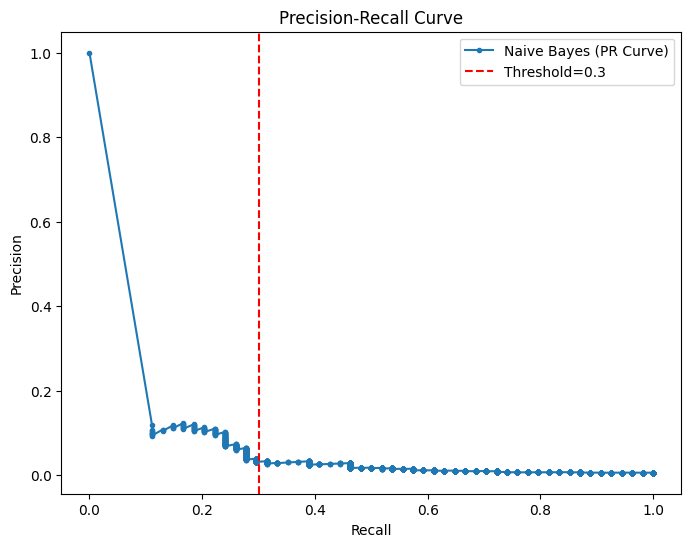

In [ ]:
# Instantiate and run the advanced model with SMOTE
nbc_model2 = NBCModel(X_train, X_test, y_train, y_test)
nbc_model2.set_model(mode="advance")  # Use the advanced mode with SMOTE

# Train the model
nbc_model2.train()

# Evaluate the model with threshold = 0.3
nbc_model2.evaluate(threshold=0.3)

# Predict with the adjusted threshold
nbc_model2.predict(threshold=0.3)

# Print evaluation metrics
print(model_cm(nbc_model2))
print(model_cr(nbc_model2))
print(model_roc_auc_score(nbc_model2))

# Plot Precision-Recall Curve
PR_Curve(nbc_model2)

Test Loss: 0.0287, Test Accuracy: 0.9940
[[9304   15]
 [  41   13]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9319
           1       0.46      0.24      0.32        54

    accuracy                           0.99      9373
   macro avg       0.73      0.62      0.66      9373
weighted avg       0.99      0.99      0.99      9373

0.9393821066479077


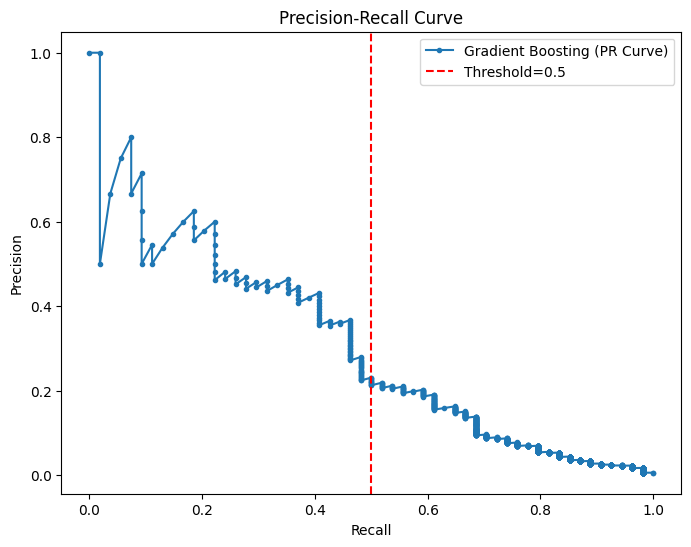

In [ ]:
# GB
gb_model = GBModel(X_train, X_test, y_train, y_test)
gb_model.set_model(mode="standard")  # Standard Gradient Boosting

# Train and evaluate
gb_model.train()
gb_model.evaluate()
gb_model.predict()

print(model_cm(gb_model))
print(model_cr(gb_model))
print(model_roc_auc_score(gb_model))

PR_Curve(gb_model)

Use LightBoosting,XGBoosting,CatBoosting to improve the result.

Epoch 1/100
2734/2734 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9103 - loss: 0.3497 - val_accuracy: 0.9924 - val_loss: 0.1047 - learning_rate: 0.0010
Epoch 2/100
2734/2734 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9939 - loss: 0.0811 - val_accuracy: 0.9937 - val_loss: 0.0563 - learning_rate: 0.0010
Epoch 3/100
2734/2734 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9939 - loss: 0.0504 - val_accuracy: 0.9939 - val_loss: 0.0470 - learning_rate: 0.0010
Epoch 4/100
2734/2734 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9933 - loss: 0.0458 - val_accuracy: 0.9939 - val_loss: 0.0435 - learning_rate: 0.0010
Epoch 5/100
2734/2734 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9936 - loss: 0.0448 - val_accuracy: 0.9946 - val_loss: 0.0375 - learning_rate: 0.0010
Epoch 6/100
2734/2734 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9941 - loss: 0.0401 - val_accuracy: 0.9936 - val_loss: 0.0409 - learning_rate: 0.0010
Epoch 7/100
2734/2734 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0

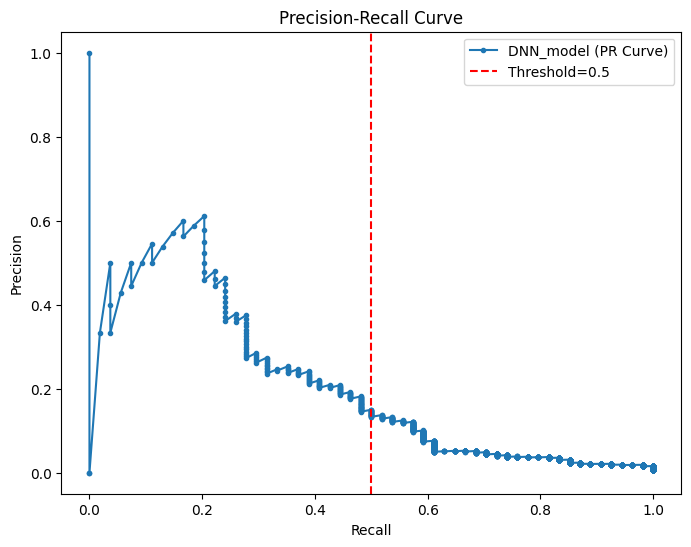

In [ ]:
DNN_model = DNN_model(X_train, X_test, y_train, y_test)
DNN_model.train()
DNN_model.evaluate()
DNN_model.predict()

print(model_cm(DNN_model))
print(model_cr(DNN_model))
print(f"ROC-AUC score: {model_roc_auc_score(DNN_model)}")
PR_Curve(DNN_model)

For the current model, the high precision but low recall for class 1 suggests that the model accurately predicts positive cases but misses many actual positive samples.

To improve recall:

*  Addressed class imbalance by using oversampling (SMOTE) and adjusting class weights to make the model more sensitive to minority class samples.

*  Adjusted the decision threshold to optimize for better recall without significantly impacting precision or overall accuracy.

*  Implemented regularization (L2) and dropout to prevent overfitting while enhancing generalization for minority class detection.

*  Incorporated focal loss to further focus on hard-to-classify positive samples.

Epoch 1/100
2734/2734 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9943 - loss: 0.0372 - val_accuracy: 0.9949 - val_loss: 0.0347 - learning_rate: 5.0000e-04
Epoch 2/100
2734/2734 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9945 - loss: 0.0312 - val_accuracy: 0.9941 - val_loss: 0.0389 - learning_rate: 5.0000e-04
Epoch 3/100
2734/2734 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9942 - loss: 0.0331 - val_accuracy: 0.9938 - val_loss: 0.0537 - learning_rate: 5.0000e-04
Epoch 4/100
2734/2734 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9947 - loss: 0.0304 - val_accuracy: 0.9938 - val_loss: 0.0444 - learning_rate: 5.0000e-04
Epoch 5/100
2734/2734 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9946 - loss: 0.0297 - val_accuracy: 0.9933 - val_loss: 0.0612 - learning_rate: 2.5000e-04
Epoch 6/100
2734/2734 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9954 - loss: 0.0265 - val_accuracy: 0.9942 - val_loss: 0.0579 - learning_rate: 2.5000e-04
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - ac

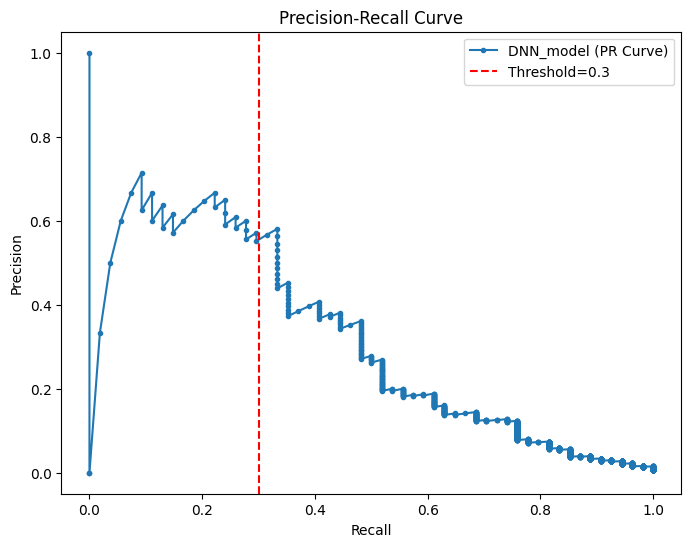

In [ ]:
DNN_model.set_model("advance")
DNN_model.train()
DNN_model.evaluate()
DNN_model.predict(threshold=0.3)

print(model_cm(DNN_model))
print(model_cr(DNN_model))
print(f"ROC-AUC score: {model_roc_auc_score(DNN_model)}")
PR_Curve(DNN_model)

0:	learn: 0.9533504	test: 0.9576409	best: 0.9576409 (0)	total: 79.5ms	remaining: 39.7s
50:	learn: 0.9796411	test: 0.9721321	best: 0.9723348 (32)	total: 1.18s	remaining: 10.4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9723348196
bestIteration = 32

Shrink model to first 33 iterations.
Test Loss: 0.0890, Test Accuracy: 0.9951
[[9308   11]
 [  35   19]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9319
           1       0.63      0.35      0.45        54

    accuracy                           1.00      9373
   macro avg       0.81      0.68      0.72      9373
weighted avg       0.99      1.00      0.99      9373

ROC-AUC score: 0.964238731703052


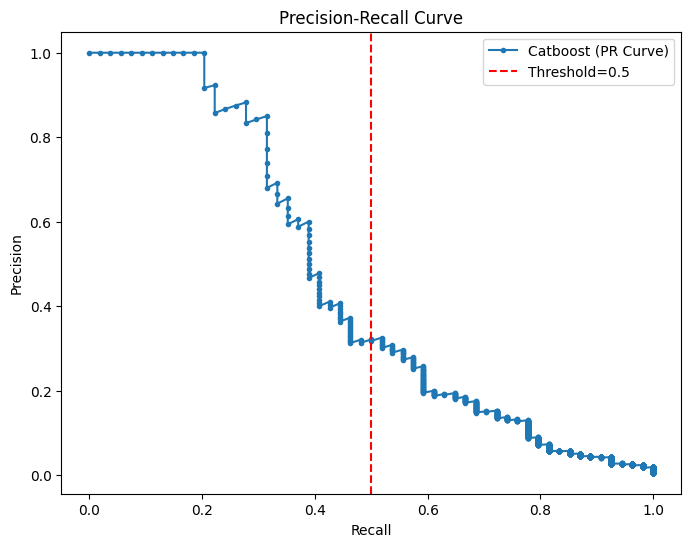

In [ ]:
catboost_model = Catboost(X_train, X_test, y_train, y_test)
catboost_model.train()
catboost_model.predict()
catboost_model.evaluate()

print(model_cm(catboost_model))
print(model_cr(catboost_model))
print(f"ROC-AUC score: {model_roc_auc_score(catboost_model)}")
PR_Curve(catboost_model)

For the current CatBoost model, the low recall for label=1 indicates that the model misses many actual positive samples. To improve recall:

* Class imbalance: Applied SMOTE for oversampling and adjusted class_weights to focus on the minority class.
* Threshold adjustment: Reduced the decision threshold to 0.3 to classify more samples as label=1.
* Model tuning: Increased iterations and tree depth to better capture minority class patterns.

0:	learn: 0.9341693	test: 0.9303129	best: 0.9303129 (0)	total: 67.1ms	remaining: 1m 6s
50:	learn: 0.9768141	test: 0.9449990	best: 0.9449990 (36)	total: 2.09s	remaining: 39s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9449990401
bestIteration = 36

Shrink model to first 37 iterations.
Test Loss: 0.1646, Test Accuracy: 0.9952
[[9309   10]
 [  35   19]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9319
           1       0.66      0.35      0.46        54

    accuracy                           1.00      9373
   macro avg       0.83      0.68      0.73      9373
weighted avg       0.99      1.00      0.99      9373

ROC-AUC score: 0.9573293112835983


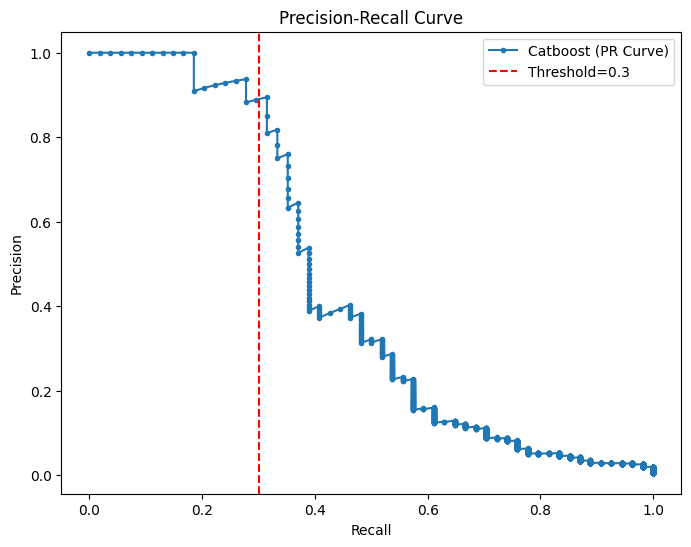

In [ ]:
catboost_model.set_model(module="advance", iterations=1000, learning_rate=0.05, depth=8, class_weights=[1, 20])
catboost_model.train()
catboost_model.predict(threshold=0.3)
catboost_model.evaluate()

print(model_cm(catboost_model))
print(model_cr(catboost_model))
print(f"ROC-AUC score: {model_roc_auc_score(catboost_model)}")
PR_Curve(catboost_model)

Training Accuracy: 1.0000
Testing Accuracy: 0.9948
[[9319    0]
 [  49    5]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      9319
           1       1.00      0.09      0.17        54

    accuracy                           0.99      9373
   macro avg       1.00      0.55      0.58      9373
weighted avg       0.99      0.99      0.99      9373

ROC-AUC: 0.9233


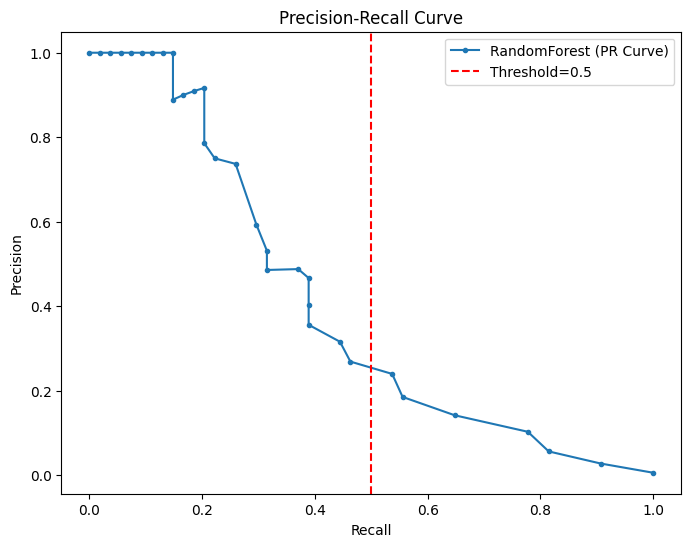

In [ ]:
# Standard Random Forest
rf_model_standard = RandomForestModel(X_train, X_test, y_train, y_test)
rf_model_standard.set_model(mode="standard")
rf_model_standard.train()
rf_model_standard.evaluate()

print(model_cm(rf_model_standard))
print(model_cr(rf_model_standard))
print(f"ROC-AUC: {model_roc_auc_score(rf_model_standard):.4f}")
PR_Curve(rf_model_standard)

Training model with parameters: {'n_estimators': 100, 'max_depth': 8}
Training model with parameters: {'n_estimators': 150, 'max_depth': 10}
Training model with parameters: {'n_estimators': 200, 'max_depth': 15}
Training model with parameters: {'n_estimators': 100, 'max_depth': None}
Best model parameters: {'n_estimators': 100, 'max_depth': None}
Best F1-Score: 0.3878
Training Accuracy: 1.0000
Testing Accuracy: 0.9948
[[9314    5]
 [  44   10]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9319
           1       0.67      0.19      0.29        54

    accuracy                           0.99      9373
   macro avg       0.83      0.59      0.64      9373
weighted avg       0.99      0.99      0.99      9373

ROC-AUC: 0.9326


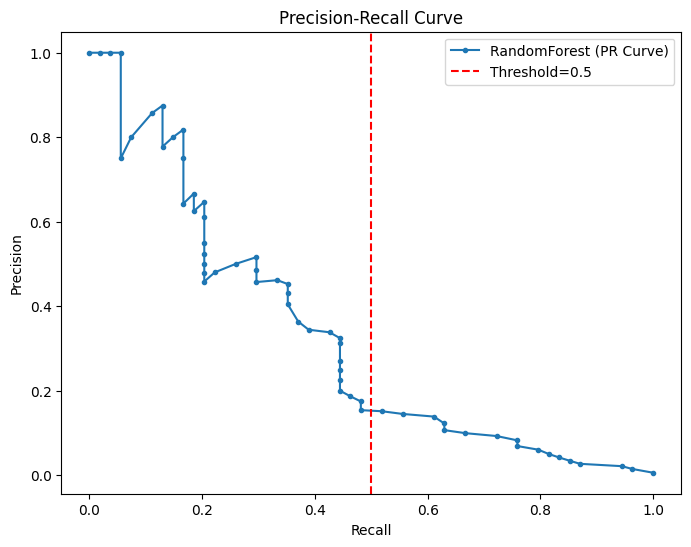

In [ ]:
# Advanced Random Forest with Hyperparameter Tuning
rf_model_advanced = RandomForestModel(X_train, X_test, y_train, y_test)
rf_model_advanced.set_model(mode="advanced")
rf_model_advanced.train()
rf_model_advanced.evaluate()

print(model_cm(rf_model_advanced))
print(model_cr(rf_model_advanced))
print(f"ROC-AUC: {model_roc_auc_score(rf_model_advanced):.4f}")
PR_Curve(rf_model_advanced)


Test Loss: 0.0171, Test Accuracy: 0.9957
Confusion Matrix:
[[9317    2]
 [  38   16]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9319
           1       0.89      0.30      0.44        54

    accuracy                           1.00      9373
   macro avg       0.94      0.65      0.72      9373
weighted avg       1.00      1.00      0.99      9373


ROC-AUC Score:
ROC-AUC: 0.9690


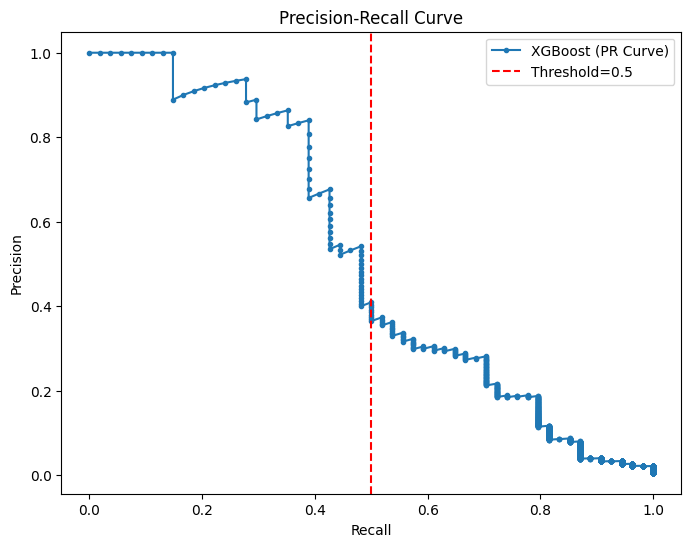

In [19]:
# Initialize the XGBoost model
xgb_model = XGBoostModel(X_train, X_test, y_train, y_test)
xgb_model.set_model(mode="standard")
xgb_model.train()
xgb_model.evaluate()
print("Confusion Matrix:")
print(model_cm(xgb_model))
print("\nClassification Report:")
print(model_cr(xgb_model))
print("\nROC-AUC Score:")
print(f"ROC-AUC: {model_roc_auc_score(xgb_model):.4f}")

PR_Curve(xgb_model)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best Parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Test Loss: 0.0169, Test Accuracy: 0.9959
Confusion Matrix:
[[9317    2]
 [  36   18]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9319
           1       0.90      0.33      0.49        54

    accuracy                           1.00      9373
   macro avg       0.95      0.67      0.74      9373
weighted avg       1.00      1.00      1.00      9373


ROC-AUC Score:
ROC-AUC: 0.9708


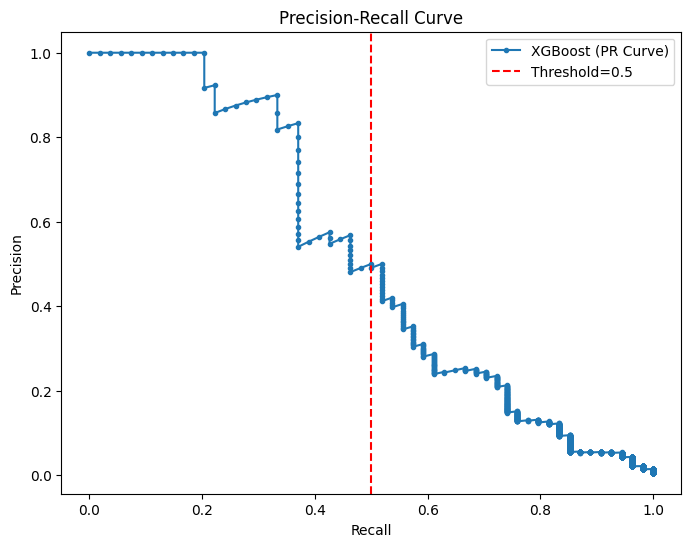

In [20]:
# param_grid for advanced mode
param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.1, 0.2],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0]
}

xgb_model = XGBoostModel(X_train, X_test, y_train, y_test)
xgb_model.set_model(mode="advanced", param_grid=param_grid)
xgb_model.train()
xgb_model.evaluate()

# Use external functions
print("Confusion Matrix:")
print(model_cm(xgb_model))
print("\nClassification Report:")
print(model_cr(xgb_model))
print("\nROC-AUC Score:")
print(f"ROC-AUC: {model_roc_auc_score(xgb_model):.4f}")

PR_Curve(xgb_model)


In [15]:
from sklearn.base import BaseEstimator, ClassifierMixin

class DNNWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, X_train, X_test, y_train, y_test, threshold=0.5, class_weight=None, module = "advance"):
        self.model = None
        self.threshold = threshold
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.class_weight = class_weight
        self.module = "advance"

    def fit(self, X, y):
        self.model = DNN_model(X_train=self.X_train, X_test=self.X_test, y_train=self.y_train, y_test=self.y_test)
        if self.module == "advance":
            self.model.set_model(module="advance")
        self.model.train()
        return self

    def predict(self, X):
        _, y_pred_proba = self.model.predict(new_data=X, threshold=self.threshold)
        y_pred = (y_pred_proba > self.threshold).astype(int)
        return y_pred

    def predict_proba(self, X):
        _, y_pred_proba = self.model.predict(new_data=X)
        # Convert to [1-p, p] format
        y_pred_proba = np.hstack([1 - y_pred_proba, y_pred_proba])
        return y_pred_proba

    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)




In [ ]:
# Initialize individual models
dnn_model = DNNWrapper(X_train, X_test, y_train, y_test, module="standard")

catboost_model = Catboost(X_train, X_test, y_train, y_test)
catboost_model.set_model(module="standard")
catboost_model.train()

svm_model = SVMModel(X_train, X_test, y_train, y_test)
svm_model.set_model(mode="standard")
svm_model.train()

nbc_model = NBCModel(X_train, X_test, y_train, y_test)
nbc_model.set_model(mode="standard")
nbc_model.train()

gb_model = GBModel(X_train, X_test, y_train, y_test)
gb_model.set_model(mode="standard")
gb_model.train()

knn_model = KNNModel(X_train, X_test, y_train, y_test)
knn_model.set_model(mode="standard")
knn_model.train()

lgbm_model = LightGBMModel(X_train, X_test, y_train, y_test)
lgbm_model.set_model(mode="standard")
lgbm_model.train()

rf_model = RandomForestModel(X_train, X_test, y_train, y_test)
rf_model.set_model(mode="standard")
rf_model.train()

xgb_model = XGBoostModel(X_train, X_test, y_train, y_test)
xgb_model.set_model(mode="standard")
xgb_model.train()


# Voting classifier (soft voting with probabilities)
voting_clf = VotingClassifier(
    estimators=[
        ('dnn', dnn_model),
        ('catboost', catboost_model.model),
        ('svm', svm_model.model),
        ('nbc', nbc_model.model),
        ('gb', gb_model.model),
        ('knn', knn_model.model),
        ('lgbm', lgbm_model.model),
        ('rf', rf_model.model),
        ('xgb', xgb_model.model)
    ],
    voting='soft'  # Use 'soft' for probability-based voting
)

# Train Voting Classifier
voting_clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = voting_clf.predict(X_test)
y_pred_proba = voting_clf.predict_proba(X_test)[:, 1]

# Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ROC-AUC
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))


0:	learn: 0.9533504	test: 0.9576409	best: 0.9576409 (0)	total: 159ms	remaining: 1m 19s
50:	learn: 0.9796411	test: 0.9721321	best: 0.9723348 (32)	total: 3.59s	remaining: 31.6s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9723348196
bestIteration = 32

Shrink model to first 33 iterations.
Epoch 1/100
2734/2734 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9128 - loss: 0.3386 - val_accuracy: 0.9938 - val_loss: 0.0966 - learning_rate: 0.0010
Epoch 2/100
2734/2734 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9943 - loss: 0.0776 - val_accuracy: 0.9940 - val_loss: 0.0570 - learning_rate: 0.0010
Epoch 3/100
2734/2734 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.9947 - loss: 0.0465 - val_accuracy: 0.9925 - val_loss: 0.0568 - learning_rate: 0.0010
Epoch 4/100
2734/2734 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.9942 - loss: 0.0413 - val_accuracy: 0.9929 - val_loss: 0.0529 - learning_rate: 0.0010
Epoch 5/100
2734/2734 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accurac

In [ ]:
# Initialize individual models
dnn_model = DNNWrapper(X_train, X_test, y_train, y_test, module="advance")

catboost_model = Catboost(X_train, X_test, y_train, y_test)
catboost_model.set_model(module="advance")
catboost_model.train()

svm_model = SVMModel(X_train, X_test, y_train, y_test)
svm_model.set_model(mode="advance")
svm_model.train()

nbc_model = NBCModel(X_train, X_test, y_train, y_test)
nbc_model.set_model(mode="advance")
nbc_model.train()

gb_model = GBModel(X_train, X_test, y_train, y_test)
gb_model.set_model(mode="standard")
gb_model.train()

knn_model = KNNModel(X_train, X_test, y_train, y_test)
knn_model.set_model(mode="advance")
knn_model.train()

lgbm_model = LightGBMModel(X_train, X_test, y_train, y_test)
lgbm_model.set_model(mode="advance")
lgbm_model.train()

rf_model = RandomForestModel(X_train, X_test, y_train, y_test)
rf_model.set_model(mode="advanced")
rf_model.train()

xgb_model = XGBoostModel(X_train, X_test, y_train, y_test)
xgb_model.set_model(mode="advanced")
xgb_model.train()


# Voting classifier (soft voting with probabilities)
voting_clf = VotingClassifier(
    estimators=[
        ('dnn', dnn_model),
        ('catboost', catboost_model.model),
        ('svm', svm_model.model),
        ('nbc', nbc_model.model),
        ('gb', gb_model.model),
        ('knn', knn_model.model),
        ('lgbm', lgbm_model.model),
        ('rf', rf_model.model),
        ('xgb', xgb_model.model)
    ],
    voting='soft'  # Use 'soft' for probability-based voting
)

# Train Voting Classifier
voting_clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = voting_clf.predict(X_test)
y_pred_proba = voting_clf.predict_proba(X_test)[:, 1]

# Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ROC-AUC
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))


0:	learn: 0.9533504	test: 0.9576409	best: 0.9576409 (0)	total: 65.9ms	remaining: 32.9s
50:	learn: 0.9796411	test: 0.9721321	best: 0.9723348 (32)	total: 3.73s	remaining: 32.8s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9723348196
bestIteration = 32

Shrink model to first 33 iterations.
Training model with parameters: {'n_estimators': 100, 'max_depth': 8}
Training model with parameters: {'n_estimators': 150, 'max_depth': 10}
Training model with parameters: {'n_estimators': 200, 'max_depth': 15}
Training model with parameters: {'n_estimators': 100, 'max_depth': None}
Best model parameters: {'n_estimators': 100, 'max_depth': None}
Best F1-Score: 0.3878
Training with parameters: {'n_estimators': 50, 'learning_rate': 0.1, 'max_depth': 3}
Training with parameters: {'n_estimators': 100, 'learning_rate': 0.05, 'max_depth': 5}
Training with parameters: {'n_estimators': 200, 'learning_rate': 0.01, 'max_depth': 7}
Best Model Parameters: {'n_estimators': 100, 'learning_rate

In [21]:
# Initialize individual models
dnn_model = DNNWrapper(X_train, X_test, y_train, y_test, module="advance")

catboost_model = Catboost(X_train, X_test, y_train, y_test)
catboost_model.set_model(module="advance")
catboost_model.train()

svm_model = SVMModel(X_train, X_test, y_train, y_test)
svm_model.set_model(mode="advance")
svm_model.train()

#nbc_model = NBCModel(X_train, X_test, y_train, y_test)
#nbc_model.set_model(mode="advance")
#nbc_model.train()

gb_model = GBModel(X_train, X_test, y_train, y_test)
gb_model.set_model(mode="standard")
gb_model.train()

#knn_model = KNNModel(X_train, X_test, y_train, y_test)
#knn_model.set_model(mode="advance")
#knn_model.train()

lgbm_model = LightGBMModel(X_train, X_test, y_train, y_test)
lgbm_model.set_model(mode="advance")
lgbm_model.train()

rf_model = RandomForestModel(X_train, X_test, y_train, y_test)
rf_model.set_model(mode="advanced")
rf_model.train()

0:	learn: 0.9533504	test: 0.9576409	best: 0.9576409 (0)	total: 26.3ms	remaining: 13.1s
50:	learn: 0.9796411	test: 0.9721321	best: 0.9723348 (32)	total: 1.18s	remaining: 10.4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9723348196
bestIteration = 32

Shrink model to first 33 iterations.
Training model with parameters: {'n_estimators': 100, 'max_depth': 8}
Training model with parameters: {'n_estimators': 150, 'max_depth': 10}
Training model with parameters: {'n_estimators': 200, 'max_depth': 15}
Training model with parameters: {'n_estimators': 100, 'max_depth': None}
Best model parameters: {'n_estimators': 100, 'max_depth': None}
Best F1-Score: 0.3878


In [25]:
# param_grid for advanced mode
param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.1, 0.2],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0]
}

xgb_model = XGBoostModel(X_train, X_test, y_train, y_test)
xgb_model.set_model(mode="advanced", param_grid=param_grid)
xgb_model.train()


Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best Parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


In [26]:
# Voting classifier (soft voting with probabilities)
voting_clf = VotingClassifier(
    estimators=[
        ('dnn', dnn_model),
        ('catboost', catboost_model.model),
        ('svm', svm_model.model),
        #('nbc', nbc_model.model),
        ('gb', gb_model.model),
        #('knn', knn_model.model),
        ('lgbm', lgbm_model.model),
        ('rf', rf_model.model),
        ('xgb', xgb_model.model)
    ],
    voting='soft'  # Use 'soft' for probability-based voting
)

# Train Voting Classifier
voting_clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = voting_clf.predict(X_test)
y_pred_proba = voting_clf.predict_proba(X_test)[:, 1]

# Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ROC-AUC
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))


Epoch 1/100
2734/2734 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.9075 - loss: 0.3588 - val_accuracy: 0.9939 - val_loss: 0.1002 - learning_rate: 0.0010
Epoch 2/100
2734/2734 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9942 - loss: 0.0840 - val_accuracy: 0.9940 - val_loss: 0.0601 - learning_rate: 0.0010
Epoch 3/100
2734/2734 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9940 - loss: 0.0503 - val_accuracy: 0.9946 - val_loss: 0.0515 - learning_rate: 0.0010
Epoch 4/100
2734/2734 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9942 - loss: 0.0417 - val_accuracy: 0.9935 - val_loss: 0.0448 - learning_rate: 0.0010
Epoch 5/100
2734/2734 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9944 - loss: 0.0383 - val_accuracy: 0.9938 - val_loss: 0.0392 - learning_rate: 0.0010
Epoch 6/100
2734/2734 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.9941 - loss: 0.0398 - val_accuracy: 0.9924 - val_loss: 0.0546 - learning_rate: 0.0010
Epoch 7/100
2734/2734 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy